In [1]:
from collections import Counter

import pandas as pd

import numpy as np
# RANDOM_SEED = 8927
# rng = np.random.default_rng(RANDOM_SEED)

import matplotlib.pyplot as plt 
import seaborn as sb
#plt.style.use("dark_background")
p = plt.rcParams
p["font.sans-serif"] = ["Roboto Condensed"]
p["font.weight"] = "light"

import bambi as bmb
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Preprocessing

We load the original dataset and parse the date-of-entry column:

In [2]:
df = pd.read_excel('../assets/amigo.xlsx')
df['date'] = pd.to_datetime(df['datum binnen'], dayfirst=True)
df = df.rename(columns={'0': 'ID'})
print(len(df))
df.sample(5)

11542


,Rangnr intrede amigo,Amigo-écrous-boek in ASB,Rangnr boek,Naam,Voornaam,Leeftijd,Geslacht,Motief arrestatie,Geboorteplaats,code geb. plaats,...,Komende van,De passage?,Beroep,Naam Voornaam,Gelijk aan vorige rij?,ID,latitude,longitude,distance,date
4770,6058,Vagabond. et mendicité,1138,Guyvt,Isidore,26,M,vagabondage,Namur,NaN,...,NaN,NaN,NaN,Guyvt Isidore,False,3127,NaN,NaN,NaN,1880-05-29
11113,8247,Vagabond. et mendicité,1795,Viselé,Elisabeth (veuve Mary),54,V,vagabondage,Bruxelles,BXL,...,NaN,NaN,NaN,Viselé Elisabeth (veuve Mary),True,7306,50.846557,4.351697,0.000207,1880-08-10
8263,11156,Vagabond. et mendicité,2637,Salbater,Jean,24,M,vagabondage,Bruxelles,BXL,...,NaN,NaN,NaN,Salbater Jean,True,5441,50.846557,4.351697,0.000207,1880-10-23
10871,9368,"Ivrognes, logés, prostitut....",5484,Vergote,Joseph Leopold,48,M,une nuit sur demande,Gand,GE,...,NaN,ja,Marchand,Vergote Joseph Leopold,False,7161,51.053829,3.725012,0.660252,1880-09-17
4766,9372,"Ivrognes, logés, prostitut....",5488,Gutt,Marie Josephine,22,V,mesure sanitaire,Montmartre France,FR,...,NaN,nee,prostituée,Gutt Marie Josephine,True,3124,46.603354,1.888334,4.906556,1880-09-17


Next, we apply some light string preprocessing:

In [33]:
df.date.min(), df.date.max()

(Timestamp('1879-10-31 00:00:00'), Timestamp('1880-11-01 00:00:00'))

In [3]:
df['code geb. plaats'] = df['code geb. plaats'].str.strip()
df['Geslacht'] = df['Geslacht'].str.lower().str.strip()
df['name'] = df['Naam'].str.strip() + ' ' + df['Voornaam'].str.strip()
df.sample(10)

,Rangnr intrede amigo,Amigo-écrous-boek in ASB,Rangnr boek,Naam,Voornaam,Leeftijd,Geslacht,Motief arrestatie,Geboorteplaats,code geb. plaats,...,De passage?,Beroep,Naam Voornaam,Gelijk aan vorige rij?,ID,latitude,longitude,distance,date,name
296,4338,Vagabond. et mendicité,669,Bastiaens,Corneille,21,m,vagabondage,Alost,OV,...,NaN,NaN,Bastiaens Corneille,False,189,51.037542,3.811783,0.572875,1880-03-31,Bastiaens Corneille
7447,3475,"Ivrognes, logés, prostitut....",1288,Peeters,Caroline ép Voorspoel,58,v,ivresse et sûreté personnelle,Geerle,NaN,...,nee,ouvrier,Peeters Caroline ép Voorspoel,False,4911,NaN,NaN,NaN,1880-02-27,Peeters Caroline ép Voorspoel
3411,226,Vagabond. et mendicité,2420,Desmedt,Guillaume,33,m,mendicité,Bruxelles,BXL,...,NaN,NaN,Desmedt Guillaume,False,2227,50.846557,4.351697,0.000207,1879-11-09,Desmedt Guillaume
1366,1547,Vagabond. et mendicité,2865,Claes,Jean Baptiste,48,m,vagabondage,Hal,BR,...,NaN,NaN,Claes Jean Baptiste,False,866,50.868652,4.788624,0.437280,1879-12-25,Claes Jean Baptiste
716,11302,"Ivrognes, logés, prostitut....",6913,Bosmans,Marie,46,v,ivresse et sûrreté personnel,Bruxelles,BXL,...,nee,ouvrier,Bosmans Marie,True,477,50.846557,4.351697,0.000207,1880-10-26,Bosmans Marie
6579,5418,"Ivrognes, logés, prostitut....",2715,Martel,Jean Baptiste,22,m,une nuit sur demande,Bruxelles,BXL,...,ja,ouvrier,Martel Jean Baptiste,True,4345,50.846557,4.351697,0.000207,1880-05-06,Martel Jean Baptiste
1665,4784,Vagabond. et mendicité,798,Couteau,Jules,18,m,vagabondage et rébellion,St Joost ten noode,BXL,...,NaN,NaN,Couteau Jules,False,1080,50.846557,4.351697,0.000207,1880-04-14,Couteau Jules
10729,3049,Vagabond. et mendicité,351,Vanstock,Marie Elisabeth,36,v,mendicité,Montaigu,FR,...,NaN,NaN,Vanstock Marie Elisabeth,False,7062,46.603354,1.888334,4.906556,1880-02-14,Vanstock Marie Elisabeth
2098,8748,"Ivrognes, logés, prostitut....",5077,De Greny,César,46,m,une nuit sur demande,Termonde,OV,...,ja,pension,De Greny César,True,1365,51.037542,3.811783,0.572875,1880-08-30,De Greny César
6649,5342,"Ivrognes, logés, prostitut....",2666,Mathy,Joseph Jean Ghislain,61,m,ivresse et sûreté personnelle,Baisy Thy,BR,...,nee,NaN,Mathy Joseph Jean Ghislain,True,4390,50.868652,4.788624,0.437280,1880-05-03,Mathy Joseph Jean Ghislain


The data has indications on the professions of people, but the labels are too unreliable and/or sparsely distributed to be of much use. The majority of men are "workers" and the majority of women "prostitutes", for instance:

In [4]:
print(df[df['Geslacht'] == 'm']['Beroep'].value_counts()[:30])
print(df[df['Geslacht'] == 'v']['Beroep'].value_counts()[:30])

Beroep
ouvrier                                 5652
garçon (de magasin, de restaurant,…)     172
employé                                  144
Marchand                                  89
colportage                                68
sans profession                           67
pension                                   19
prostituée                                 2
Name: count, dtype: int64
Beroep
prostituée                              690
ouvrier                                 468
sans profession                          35
colportage                               15
Marchand                                  5
garçon (de magasin, de restaurant,…)      1
employé                                   1
Name: count, dtype: int64


The data also has a motif for the arrests, but these labels are quite fuzzy (often overlapping) and generally unreliable, although the level *une nuit sur demande* ('a night on request') in this column is important: this level indicates that the individual was not arrested against their will, but rather that they themselves requested to stay the night (because they couldn't find refuge anywhere else for some reason). In those cases, the initiative for the night stayed in prison clearly lies with the individual instead of the police force.

In [5]:
df["Naam"].value_counts().head(30)

Naam
Janssens        42
De Wandel       40
Peeters         38
Maes            38
Mertens         35
Jacobs          33
Desmet          33
Desmedt         32
Wauters         31
De Vos          28
Dumont          27
Crickx          26
Vandenbosch     24
Depauw          24
Lebrun          24
De Greef        23
Bosmans         23
Hofman          23
Simon           22
De Backer       22
Laes            22
De Coster       22
Smets           21
Dubois          21
Stevens         18
Vanhemelryck    17
Laureys         17
Leemans         17
Claes           17
Segers          17
Name: count, dtype: int64

We load an auxiliary spreadsheet that maps the place of births to three `origins`: 
  - `BXL`: born in Brussels
  - `BE`: born in Belgium
  - `ABROAD`: born outside of Belgium

We map those in a lookup dictionary for later use:

In [6]:
origin_df = pd.read_excel('../assets/place_codes.xlsx', header=0).fillna("")
code2origin = {code.strip():o.strip() for code, o in zip(origin_df['abbreviation'], origin_df['origin'])}
origin_df.sample(5)

,abbreviation,label,origin
15,IR,Ierland,ABROAD
20,MART,Martinique,ABROAD
9,ENG,Engeland,ABROAD
26,pLux,Provincie Luxemburg,BE
24,OV,Provincie Oost-Vlaanderen,BE


Each individual in the dataset has manually been disambigiuated and received a unique numeric code in the `ID` column. We can already get an impression of the recidivism in the data:

In [7]:
print(len(df['ID'].unique()))
print(df.groupby('ID').size().sort_values()[::-1][:10])

7562
ID
1608    35
1116    22
7310    16
7020    14
3362    14
3913    14
3251    14
3069    14
2229    14
4457    12
dtype: int64


Some people occur frequently in the data, although the large majority are singletons and doubletons:

In [8]:
df.groupby('ID').size().value_counts().sort_index()

1     5565
2     1128
3      422
4      210
5       96
6       43
7       43
8       20
9       11
10       9
11       2
12       4
14       6
16       1
22       1
35       1
Name: count, dtype: int64

How many individuals occur in the entire dataset? How many nights were spent in the Amigo in total?

In [9]:
print(len(df))
print(df['name'].nunique())

11542
7478


How many nights did the average person spend in the Amigo prison:

In [10]:
df['name'].nunique() / len(df)

0.6478946456420032

The data needs to be splitted in two different datasets: one for the individuals who forcefully entered prison, and one for individuals who spent the night there on their own request:

In [11]:
print(len(df))
df_demande = df[df['Motief arrestatie'] == 'une nuit sur demande']
df_arrestation = df[df['Motief arrestatie'] != 'une nuit sur demande']
print(len(df_demande))
print(len(df_arrestation))

11542
3172
8370


In [12]:
df_arrestation.groupby('ID').size().value_counts()

1     4707
2      851
3      244
4      100
5       44
6       26
7       18
8       11
10       5
11       3
9        2
12       2
14       2
22       1
35       1
13       1
16       1
Name: count, dtype: int64

## Ratio plots

Böhning et al. recommend to use ratio plots to determine whether there is unexplained heterogeneity in the data:

In [13]:
# def ratio(f):
#     ratios = []
#     for i in range(len(f) - 1):
#         if f[i] == 0 or f[i + 1] == 0:
#             r = 0
#         else:
#             r = (i + 2) * f[i + 1] / f[i]
#             if np.isnan(r) or np.isinf(r):
#                 ratios.append(0)
#         ratios.append(r)        
#     return ratios

#let f_x denote the frequency of units detected exactly x times

def ratio(f):
    ratios = [0]
    X, fX = zip(*f.items())
    for i in range(len(X) - 1):
        if fX[i] == 0 or fX[i + 1] == 0:
            r = 0
        else:
            r = (X[i] + 1) * fX[i + 1] / fX[i]
            if np.isnan(r) or np.isinf(r):
                ratios.append(0)
        ratios.append(r)        
    return ratios

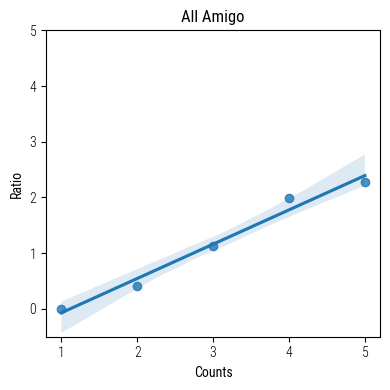

In [14]:
counts = df.groupby('ID').size().values

F = pd.Series(counts).value_counts().sort_index()[:5]
Fs, Rs = F.index, ratio(F)

fig, ax = plt.subplots(figsize=(4, 4))
sb.regplot(x=np.array(Fs), y=np.array(Rs), ax=ax);
plt.ylabel('Ratio')
plt.xlabel('Counts');
plt.title('All Amigo')
plt.ylim(-0.5, 5)
plt.tight_layout();

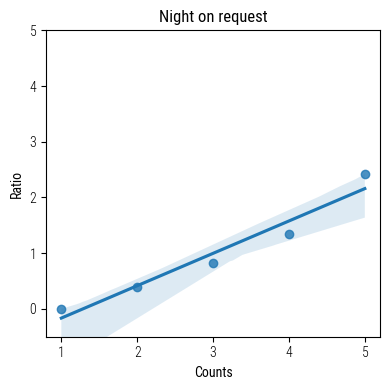

In [15]:
counts = df_demande.groupby('ID').size().values

F = pd.Series(counts).value_counts().sort_index()[:5]
Fs, Rs = F.index, ratio(F)

fig, ax = plt.subplots(figsize=(4, 4))
sb.regplot(x=np.array(Fs), y=np.array(Rs), ax=ax);
plt.ylabel('Ratio')
plt.xlabel('Counts');
plt.title('Night on request')
plt.ylim(-0.5, 5)
plt.tight_layout();

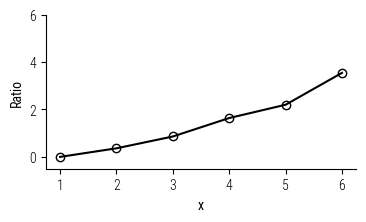

In [16]:
counts = df_arrestation.groupby('ID').size().values

F = pd.Series(counts).value_counts().sort_index()[:6]
Fs, Rs = F.index, ratio(F)

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(np.array(Fs), np.array(Rs), 'k-o',  mfc='none')
ax.set(ylabel="Ratio", xlabel="x")
plt.ylim(-0.5, 6)
ax.spines[['right', 'top']].set_visible(False)
fig.savefig("../viz/ratio.png", dpi=300)

For all subsets of the data, this ratio plot should present as a straight horizontal line, *if there were no heterogeneity*: this is clearly not the case, indicating that there is indeed unobserved heterogeneity in the data which cannot be can be ignored. Put differently, the assumption of homogeneity in the underlying Poisson process is violated, meaning that the Zelterman estimator should be preferred over a (simple) untruncated Poisson model.

## Zelterman data

We define a function to convert both subsets of the data to a format that is suitable for the statistical analysis in the next notebook. In the resulting dataset, each row represents a single individual, for whom we record:
- `id`: a unique identifier [category with many levels]
- `count`: the number of nights which the individual spent at the Amigo prison [*integer*];
- `age`: the (average) age of the individual, expressed in years [*scalar*];
- `sex`: the (binary) sex of the individual [*category with two levels*];
- `origin`: whether the individual was born in Brussels (BXL), Belgium (BE) or elsewhere (ABROAD) [*category with three levels*];
- `prior`: whether the individual (voluntarily) spent a night on their own request in the Amigo prison, *before* the first (unvoluntary) arrest [*category with two levels*];
- `family`: whether other individuals with the same family name occur in the dataset [*category with two levels*].

In [17]:
def encode(df, df_other=None):
    recid = []
    no_locations = set()

    for name, group in df.groupby('ID'):
        # Check whether the individual occurs in the night-on-request date before
        # the date of the first forceful arrest:
        other = 'no prior'
        if name in set(df_other['ID']):
            earliest_date = group['date'].sort_values(ascending=True).iloc[0]
            earliest_other_date = df_other[df_other['ID'] == name]['date'].sort_values(ascending=True).iloc[0]
            if earliest_other_date < earliest_date:
                other = 'prior'
        
        # The total number of nights spent at Amigo, but only after being arrested:
        count = len(group)
        
        # The mean age at time of arrest:
        ages = np.array([a for a in group['Leeftijd'] if not isinstance(a, str)])
        if len(ages) == 0:
            age = None
        elif len(set(ages)) > 1:
            age = np.median(ages)
        else:
            age = ages[0]

        # The most commonly listed sex for the individual:
        _counts = Counter(group['Geslacht'].values).most_common()
        sex = Counter(group['Geslacht'].values).most_common(1)[0][0]
        if sex == 'm': 
            sex = 'male'
        else:
            sex = 'female'
        
        # The most commonly listed origin for the individual, but assuming that Brussels is the default:
        origin = Counter(group['code geb. plaats'].values).most_common(1)[0][0]
        try:
            new_origin = code2origin[origin]
        except KeyError:
            no_locations.add(name)
            new_origin = 'BXL' # CHECK: this assumes all NaN are from Brussels? Can't we simply leave them out?

        # Keep track of the individual's most commonly listed family name:
        family = Counter(group['Naam'].values).most_common(1)[0][0]

        recid.append((name, count, age, sex, new_origin, other, family, origin))

    # create a dataframe:
    recid = pd.DataFrame(recid, columns=('id', 'count', 'age', 'sex', 'origin', 'prior', 'family', 'origin_org'))

    # only keep individuals for which we have an age and origin:
    recid = recid[~recid['age'].isnull()]
    recid = recid[~recid['origin'].isna()]
    
    # record whether other individuals with the same family name occur elsewhere in the dataset:
    recid['family'] = recid['family'].str.strip().str.lower()
    family_names = Counter(recid['family'])
    family = ['family' if family_names[f] > 1 else 'no family' for f in recid['family']]
    recid['family'] = family
    recid["assumed_origin"] = False
    recid.loc[recid["id"].isin(no_locations), "assumed_origin"] = True
    
    return recid

In [18]:
recid_demande = encode(df_demande, df_other=df_arrestation)
print(len(recid_demande['id'].unique()))
recid_demande.sample(10)

2363


,id,count,age,sex,origin,prior,family,origin_org,assumed_origin
562,1788,1,18.0,male,BXL,prior,family,BXL,False
1337,4176,1,35.0,male,BXL,no prior,family,BXL,False
267,773,1,12.0,female,BE,no prior,family,OV,False
211,646,1,54.0,male,BE,no prior,no family,BR,False
2319,7403,1,49.0,male,BE,no prior,no family,LU,False
1184,3732,1,15.0,male,BXL,prior,no family,BXL,False
218,661,1,49.0,male,ABROAD,no prior,family,ENG,False
732,2358,2,19.0,male,ABROAD,no prior,no family,FR,False
1162,3659,1,24.0,male,ABROAD,no prior,no family,DL,False
680,2188,1,40.0,female,ABROAD,no prior,family,FR,False


In [19]:
recid_arrestation = encode(df_arrestation, df_other=df_demande)
print(len(recid_arrestation['id'].unique()))
recid_arrestation.sample(10)

6016


,id,count,age,sex,origin,prior,family,origin_org,assumed_origin
2663,3345,2,26.0,male,BE,no prior,no family,BR,False
270,350,2,26.0,female,BE,no prior,no family,A,False
4253,5384,2,22.0,male,BE,no prior,no family,LU,False
332,435,1,52.0,male,BXL,no prior,family,BXL,False
3383,4295,1,42.0,male,BXL,prior,family,BXL,False
927,1191,2,25.0,male,BXL,no prior,family,BXL,False
3710,4692,1,43.0,male,BXL,no prior,no family,BXL,False
4666,5905,1,24.0,male,BXL,no prior,family,BXL,False
4882,6177,1,22.0,male,BXL,no prior,no family,BXL,False
5214,6598,2,55.0,female,BE,no prior,no family,WV,False


We describe the distribution of counts in the preprocessed dataset in a table:

In [20]:
N = recid_arrestation['count'].sum()
fs = recid_arrestation['count'].value_counts().sort_index()
fs = pd.DataFrame(fs)
#fs.index = ['$f_{{'+str(i)+'}}$' for i in fs.index]
fs.index = ['f'+str(i) for i in fs.index]
#fs.loc['$N$'] = N
fs.loc['N'] = N
#fs.loc['$S_{{obs}}$'] = len(recid_arrestation)
fs.loc['S obs'] = len(recid_arrestation)
fs['f'] = fs.index
fs = pd.DataFrame(fs).transpose().drop('f')
print(fs.to_latex(index=False))
fs


\begin{tabular}{lllllllllllllllllll}
\toprule
f1 & f2 & f3 & f4 & f5 & f6 & f7 & f8 & f9 & f10 & f11 & f12 & f13 & f14 & f16 & f22 & f35 & N & S obs \\
\midrule
4704 & 851 & 244 & 100 & 44 & 26 & 18 & 11 & 2 & 5 & 3 & 2 & 1 & 2 & 1 & 1 & 1 & 8367 & 6016 \\
\bottomrule
\end{tabular}



,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f16,f22,f35,N,S obs
count,4704,851,244,100,44,26,18,11,2,5,3,2,1,2,1,1,1,8367,6016


We write away the files for the statistical analysis:

In [21]:
recid_demande.to_excel('../assets/recid_demande.xlsx', header=True, index=False)
recid_arrestation.to_excel('../assets/recid_arrestation.xlsx', header=True, index=False)

#### Time-to-recapture

*Note*: we only have a date for the date of entry into the prison, not for the date of release from custody. De Koster & Erkul (2022) do not give any details on the exact length of a stay but do note that individuals (occasionally?) were sent to a colony outside of town. There seem to be many cases, however, where people returned to the city after a stay in a colony and reappear in the sources. We will return to this issue later.

For the simulation models, it is useful to know what the average *time-to-recapture* is for a recidivist:

In [22]:
time2recapture = []

for name, group in df.groupby('ID'):
    if len(group) < 2:
        continue
    # sort the capture events in time:
    dates = group['date'].sort_values(ascending=True)
    # collect the time lapse (in days) between two consecutive events:
    for i in range(len(dates) - 1):
        timelapse = (dates.iloc[i + 1] - dates.iloc[i]).days
        # record how often the individual has been apprehended:
        capture_event = i + 2
        time2recapture.append((timelapse, capture_event, group["Geslacht"].iloc[0]))

time2recapture = pd.DataFrame(time2recapture, columns=('timelapse', 'capture', "sex"))
time2recapture

,timelapse,capture,sex
0,73,2,m
1,2,2,m
2,193,2,v
3,2,3,v
4,48,2,m
...,...,...,...
3975,91,3,m
3976,67,2,m
3977,148,3,m
3978,141,2,m


In [23]:
time2recapture['timelapse'].describe()

count    3980.000000
mean       57.843216
std        75.120983
min         0.000000
25%         2.000000
50%        20.000000
75%        93.000000
max       357.000000
Name: timelapse, dtype: float64

Most individuals are recaptured relatively soon (i.e. within weeks) after the previous capture:

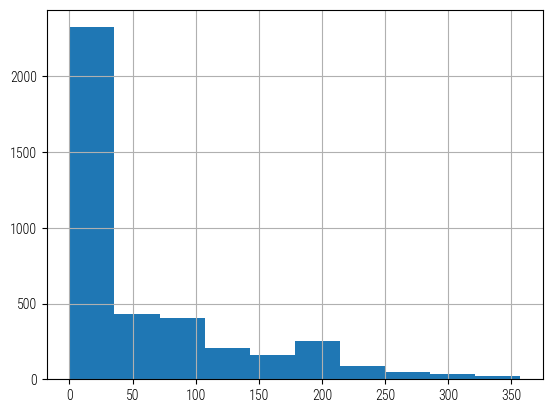

In [24]:
time2recapture['timelapse'].hist();

A majority of recaptures in fact happens the day(s) immlediately following the initial capture/arrest:

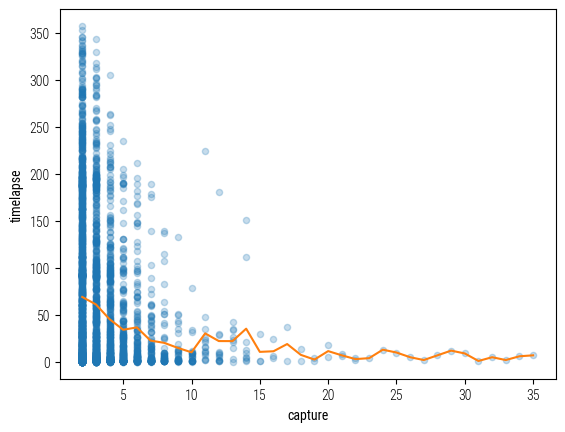

In [25]:
ax = time2recapture.plot.scatter(x='capture', y='timelapse', alpha=.25)
time2recapture.groupby('capture')['timelapse'].mean().plot(c='C1', ax=ax);

More principled approach, using a Poisson analysis:

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:06

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.580,0.005,4.570,4.589,0.0,0.0,6484.0,6323.0,1.0
capture,-0.174,0.002,-0.177,-0.170,0.0,0.0,6079.0,5753.0,1.0


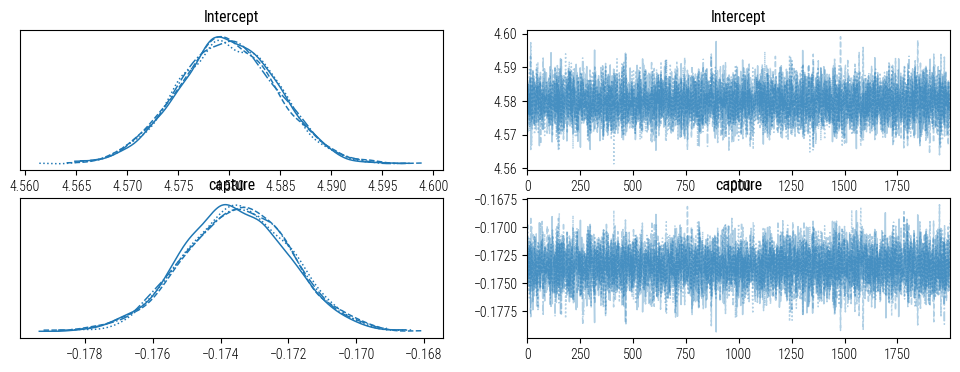

In [26]:
model = bmb.Model('timelapse ~ capture', time2recapture, family='poisson')
idata = model.fit(draws=2000, tune=2000)
az.plot_trace(idata);

az.summary(idata, hdi_prob=0.95)

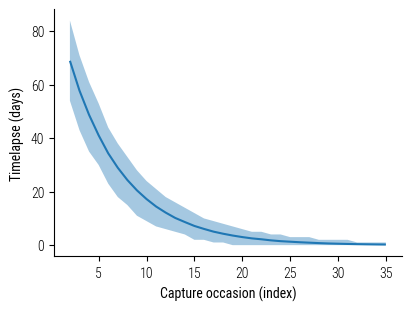

In [27]:
fig, ax = plt.subplots(figsize=(4, 3), layout="constrained")
#ax = time2recapture.plot.scatter(x='capture', y='timelapse', alpha=.05, ax=ax, c='lightgrey')
bmb.interpret.plot_predictions(model, idata, "capture", pps=True, prob=0.94, ax=ax)
ax.set_xlabel('Capture occasion (index)')
ax.set_ylabel('Timelapse (days)')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('../viz/time2recapture.png', transparent=True, dpi=300)

Interestingly, the more frequently an individual has been arrested before, the shorter the timelapse between consecutive arrest events progressively becomes -- the police seem to lose their patience and increase their arrest effort.

Finally, let us plot the arrest trajectories for some randomly picked individuals over time:

In [28]:
df.loc[df["ID"].isin(recid_arrestation.loc[recid_arrestation["count"] > 10, "id"].values), "name"].unique()

array(['Bosmans Marie', 'Crickx Thérése', 'De Wandel Joseph',
       'Dutré Clemence', 'Graftman Pierre Joseph', 'Hofman Jean Baptiste',
       'Laureys François', 'Lebrun Pierre Joseph', 'Olieslagers Félix',
       'Vanhoorick Jean', 'Vivario Joseph'], dtype=object)

In [29]:
def plot_individual(name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    (df.set_index("date")["name"] != "").astype(int).plot(
        style="|", color="grey", alpha=0.01, markersize=140, rot=0, ax=ax)
    recidivist = (df.set_index("date").sort_index()["name"] == name)
    recidivist[recidivist].astype(int).plot(
        style="|", color="C3", alpha=1, markersize=180, ax=ax)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha="center", fontsize=12)
    ax.axes.get_yaxis().set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.set_xlabel("")
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.set_title(name, loc="left", fontsize=20)

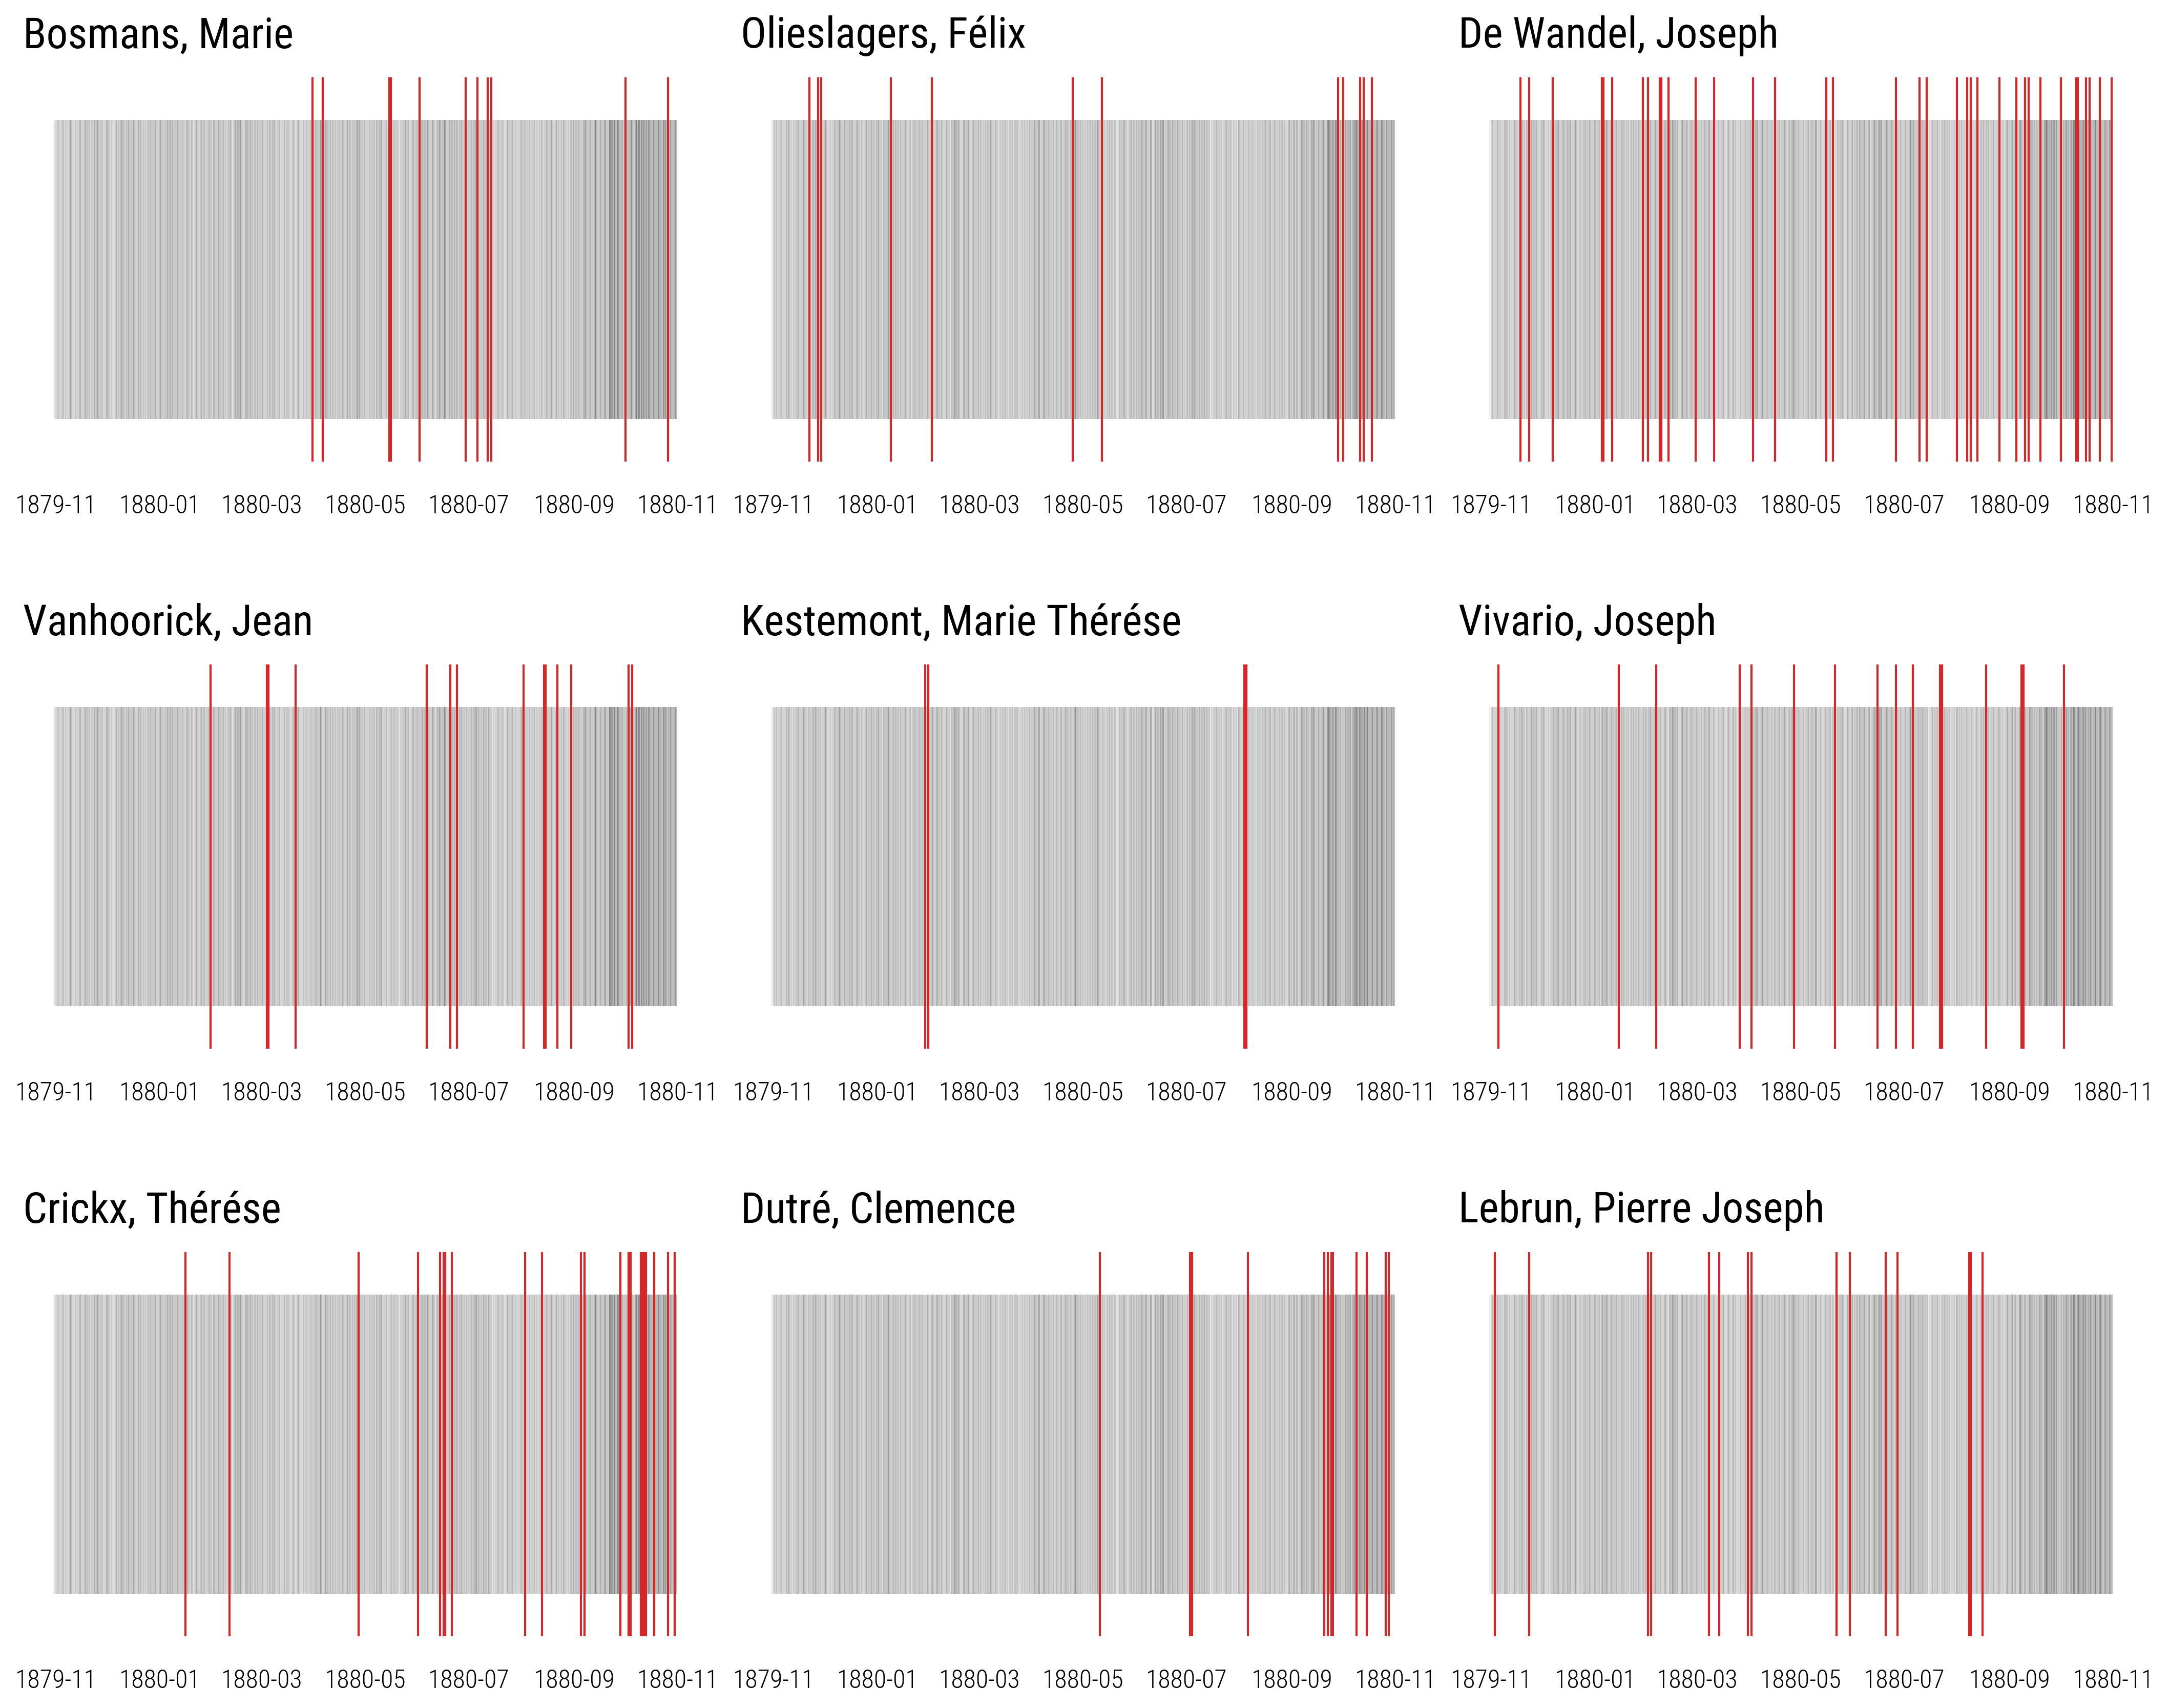

In [30]:
individuals = ['Bosmans, Marie', 'Olieslagers, Félix', 'De Wandel, Joseph', 
               'Vanhoorick, Jean', 'Kestemont, Marie Thérése', 'Vivario, Joseph', 
               'Crickx, Thérése', 'Dutré, Clemence', 'Lebrun, Pierre Joseph']

df["name"] = df["Naam"] + ", " + df["Voornaam"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 11), dpi=300, layout="constrained")
axes = axes.flatten()
for i, ind in enumerate(individuals):
    plot_individual(ind, ax=axes[i])
fig.get_layout_engine().set(hspace=0.15)
fig.savefig("../viz/recidivists-large.png", dpi=300, transparent=True)

For these (frequent) recidivists, the arrest patterns have a clear "burstiness" to them: consecutive arrests cluster in time and tend to succeed each other rather rapidly. This shows that stays in Amigo were probably shortlived, but not indicate whether individuals, in between arrest clusters remained in town or were temporarily sent to institutions outside of town. If the latter occured, it is clear that individuals could indeed well return to town. Some of the model assumptions, in particular that of a closed populations, are therefore partially violated, but it is unclear to which extent.